In [1]:
import torch
import pickle
import os
import pathlib as Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display

current_path = os.getcwd()
parent_dir = os.path.dirname(current_path)
sys.path.append(parent_dir)
path_dynamics_model_weights = os.path.join(parent_dir, "old_files", "dynamics_model_weights_encoder")
import old_files.dynamics_learning_encoder.mlmodel_encoder as mlmodel
device = torch.device('cuda:1')

dynamics_model = mlmodel.load_model("run_4_encoder_increased_wind30.pth", path_dynamics_model_weights)
dynamics_model.mu.to(device)
dynamics_model.f.to(device)
dynamics_model.g.to(device)

g(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [2]:
class RealWorldDataset():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.trajectories = set(self.data['traj'].values)
        self.num_trajectories = len(self.trajectories)
        print("path :", data_path, "Number of trajectories: ", self.num_trajectories)
        self.trajectory_data = {}
        self.a_g = 9.81  # gravity
        self.dt = 0.01  # time step between measurements

        for traj in self.trajectories:
            traj_data = self.data[self.data['traj'] == traj]
            self.trajectory_data[traj] = {}

            for header in self.data.columns:
                self.trajectory_data[traj][header] = traj_data[header].values
        
        for traj in self.trajectories:
            self.trajectory_data[traj]['ax_nominal'], self.trajectory_data[traj]['ay_nominal'] = self.nominal_inference(
                self.trajectory_data[traj]['roll'], self.trajectory_data[traj]['pitch']
            )
            self.trajectory_data[traj]['ax_error'] = self.trajectory_data[traj]['ax'] - self.trajectory_data[traj]['ax_nominal']
            self.trajectory_data[traj]['ay_error'] = self.trajectory_data[traj]['ay'] - self.trajectory_data[traj]['ay_nominal']
        
        for traj in self.trajectories:
            self.trajectory_data[traj]['ax_NN'], self.trajectory_data[traj]['ay_NN'] = self.NN_dynamics_inference_zero_wind(
                self.trajectory_data[traj]['vx'], self.trajectory_data[traj]['vy'],
                self.trajectory_data[traj]['roll'], self.trajectory_data[traj]['pitch']
            )
            self.trajectory_data[traj]['ax_NN_error'] = self.trajectory_data[traj]['ax'] - self.trajectory_data[traj]['ax_NN']
            self.trajectory_data[traj]['ay_NN_error'] = self.trajectory_data[traj]['ay'] - self.trajectory_data[traj]['ay_NN']
        
        ## rollout the nominal model for each trajectory
        for traj in self.trajectories:
            initial_state = (self.trajectory_data[traj]['px'][0], self.trajectory_data[traj]['py'][0],
                             self.trajectory_data[traj]['vx'][0], self.trajectory_data[traj]['vy'][0])
            acceleration = np.stack((self.trajectory_data[traj]['ax_nominal'], self.trajectory_data[traj]['ay_nominal']), axis=1)
            trajectory_rollout = self.rollout_nominal_model(initial_state, acceleration)
            self.trajectory_data[traj]['px_rollout_nominal'] = trajectory_rollout[:, 0]
            self.trajectory_data[traj]['py_rollout_nominal'] = trajectory_rollout[:, 1]
            self.trajectory_data[traj]['vx_rollout_nominal'] = trajectory_rollout[:, 2]
            self.trajectory_data[traj]['vy_rollout_nominal'] = trajectory_rollout[:, 3]

        ## rollout the NN model for each trajectory
        for traj in self.trajectories:
            initial_state = (self.trajectory_data[traj]['px'][0], self.trajectory_data[traj]['py'][0],
                             self.trajectory_data[traj]['vx'][0], self.trajectory_data[traj]['vy'][0])
            control = np.stack((self.trajectory_data[traj]['roll'], self.trajectory_data[traj]['pitch']), axis=1)
            trajectory_rollout = self.rollout_NN_model_zero_wind(initial_state, control)
            self.trajectory_data[traj]['px_rollout_NN'] = trajectory_rollout[:, 0]
            self.trajectory_data[traj]['py_rollout_NN'] = trajectory_rollout[:, 1]
            self.trajectory_data[traj]['vx_rollout_NN'] = trajectory_rollout[:, 2]
            self.trajectory_data[traj]['vy_rollout_NN'] = trajectory_rollout[:, 3]

    def nominal_inference(self, roll, pitch):
        a_x_nominal = -self.a_g * np.tan(pitch)
        a_y_nominal = -self.a_g * np.tan(roll)
        return a_x_nominal, a_y_nominal 

    def NN_dynamics_inference_zero_wind(self, v_x, v_y, roll, pitch):
        v_x = torch.tensor(v_x, dtype=torch.float32).to(device)           # []
        v_y = -torch.tensor(v_y, dtype=torch.float32).to(device)
        velocity = torch.stack((v_x, v_y), dim=1)  # [N, 2]
        roll = torch.tensor(-roll, dtype=torch.float32).to(device)
        pitch = torch.tensor(-pitch, dtype=torch.float32).to(device)
        control = torch.stack((pitch, roll), dim=1)  # [N, 2]

         # NN prediction with zero wind
        with torch.no_grad():
            wind_zero = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)  # [1, 2]
            wind_encoding_zero = dynamics_model.mu(wind_zero)  # [1, latent_dim]
            wind_encoding_zero = wind_encoding_zero.repeat(velocity.shape[0], 1)
            output_NN = dynamics_model.f(torch.cat([velocity, wind_encoding_zero], dim=1)) + \
                        torch.matmul(dynamics_model.g(velocity).reshape(-1, 2, 2), control.unsqueeze(-1)).squeeze(-1)  # [N, 2]
            a_x_NN = output_NN[:, 0].cpu().numpy()
            a_y_NN = -output_NN[:, 1].cpu().numpy()
        return a_x_NN, a_y_NN
    
    def rollout_nominal_model(self, initial_state, acceleration):
        """
        initial_state: (p_x, p_y, v_x, v_y)
        acceleration : [N, 2] (a_x, a_y)
        """
        p_x, p_y, v_x, v_y = initial_state
        dt = self.dt
        trajectory = []

        for a_x, a_y in acceleration:
            v_x += a_x * dt
            v_y += a_y * dt

            p_x += v_x * dt
            p_y += v_y * dt

            trajectory.append((p_x, p_y, v_x, v_y))

        return np.array(trajectory)

    def rollout_NN_model_zero_wind(self, initial_state, control):
        """
        initial_state: (p_x, p_y, v_x, v_y)
        control : [N, 2] (pitch, roll)
        """
        p_x, p_y, v_x, v_y = initial_state
        dt = self.dt
        trajectory = []

        for roll, pitch in control:
            # NN prediction with zero wind
            a_x_NN, a_y_NN = self.NN_dynamics_inference_zero_wind(
                np.array([v_x]), np.array([v_y]),
                np.array([roll]), np.array([pitch])
            )
            a_x_NN = a_x_NN[0]
            a_y_NN = a_y_NN[0]

            # Update velocity
            v_x += a_x_NN * dt
            v_y += a_y_NN * dt

            # Update position
            p_x += v_x * dt
            p_y += v_y * dt

            trajectory.append((p_x, p_y, v_x, v_y))

        return np.array(trajectory)


In [3]:
data_no_wind = RealWorldDataset('../real_world_data/flight_data_no_wind.csv')
data_wind = RealWorldDataset('../real_world_data/flight_data_wind.csv')

path : ../real_world_data/flight_data_no_wind.csv Number of trajectories:  38
path : ../real_world_data/flight_data_wind.csv Number of trajectories:  34


In [ ]:
# Display the roll, pitch, yaw of a traj in degrees
traj_ids = sorted(list(data_no_wind.trajectory_data.keys()))
data_no_wind.index_to_traj = traj_ids
data_no_wind.trajectory_data = {i: data_no_wind.trajectory_data[traj_ids[i]] for i in range(len(traj_ids))}

print(f"Mapped {len(traj_ids)} trajectories to indices 0..{len(traj_ids)-1}")
print("Example index->traj id (first 10):", list(enumerate(traj_ids))[:10])

# ensure slider max matches available trajectories
index_slider = ipywidgets.IntSlider(
    value=min(3, data_no_wind.num_trajectories - 1),
    min=0,
    max=data_no_wind.num_trajectories - 1,
    step=1,
    description='Trajectory Index:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

out = ipywidgets.Output()

def plot_trajectory(index):
    plt.figure(figsize=(10, 6))
    plt.plot(np.rad2deg(data_no_wind.trajectory_data[index]['roll']), label='roll')
    plt.plot(np.rad2deg(data_no_wind.trajectory_data[index]['pitch']), label='pitch')
    plt.plot(np.rad2deg(data_no_wind.trajectory_data[index]['yaw']), label='yaw')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (degrees)')
    plt.title(f'Trajectory {index}')
    plt.legend()
    plt.grid(True)
    plt.show()

def _on_slider_change(change):
    if change['name'] == 'value':
        with out:
            out.clear_output(wait=True)
            plot_trajectory(change['new'])

# attach observer and display
index_slider.observe(_on_slider_change, names='value')
display(index_slider, out)

# draw initial plot
with out:
    plot_trajectory(index_slider.value)

Mapped 38 trajectories to indices 0..37
Example index->traj id (first 10): [(0, np.int64(0)), (1, np.int64(1)), (2, np.int64(2)), (3, np.int64(3)), (4, np.int64(4)), (5, np.int64(5)), (6, np.int64(6)), (7, np.int64(7)), (8, np.int64(8)), (9, np.int64(9))]


IntSlider(value=3, continuous_update=False, description='Trajectory Index:', max=37)

Output()

In [ ]:
# slider to browse trajectories and update the a_x / a_y plots
idx =0
traj_slider = ipywidgets.IntSlider(
    value=idx,
    min=0,
    max=data_no_wind.num_trajectories - 1,
    step=1,
    description='Trajectory Index:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

def _update_plots(change):
    i = change['new'] if isinstance(change, dict) else change
    with out:
        out.clear_output(wait=True)
        fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        axes[0].plot(data_no_wind.trajectory_data[i]['ax'], label='ax measured')
        axes[0].plot(data_no_wind.trajectory_data[i]['ax_nominal'], label='ax nominal')
        axes[0].plot(data_no_wind.trajectory_data[i]['ax_NN'], label='ax NN zero wind')
        axes[0].set_ylabel('a_x (m/s^2)')
        axes[0].set_title(f'Trajectory {i} - a_x')
        axes[0].legend()
        axes[0].grid(True)

        axes[1].plot(data_no_wind.trajectory_data[i]['ay'], label='ay measured')
        axes[1].plot(data_no_wind.trajectory_data[i]['ay_nominal'], label='ay nominal')
        axes[1].plot(data_no_wind.trajectory_data[i]['ay_NN'], label='ay NN zero wind')
        axes[1].set_ylabel('a_y (m/s^2)')
        axes[1].set_xlabel('Time Step')
        axes[1].set_title(f'Trajectory {i} - a_y')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

# hook up observer and display
traj_slider.observe(_update_plots, names='value')
display(traj_slider, out)

# draw initial plot
_update_plots({'new': traj_slider.value})

IntSlider(value=0, continuous_update=False, description='Trajectory Index:', max=37)

Output()

In [6]:
# Plot absolute errors for nominal vs NN models (ax and ay) with widgets to pick dataset & trajectory
dataset_map = {'No wind': data_no_wind, 'With wind': data_wind}

dataset_dropdown = ipywidgets.Dropdown(
    options=list(dataset_map.keys()),
    value='No wind',
    description='Dataset:'
)

traj_idx_slider_err = ipywidgets.IntSlider(
    value=0,
    min=0,
    max=dataset_map[dataset_dropdown.value].num_trajectories - 1,
    step=1,
    description='Trajectory:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

out_err = ipywidgets.Output()

def plot_abs_errors(dataset, idx):
    d = dataset.trajectory_data[idx]
    ax = np.array(d['ax'])
    ay = np.array(d['ay'])
    ax_nom = np.array(d['ax_nominal'])
    ay_nom = np.array(d['ay_nominal'])
    ax_nn = np.array(d['ax_NN'])
    ay_nn = np.array(d['ay_NN'])

    err_nom_ax = np.abs(ax - ax_nom)
    err_nn_ax = np.abs(ax - ax_nn)
    err_nom_ay = np.abs(ay - ay_nom)
    err_nn_ay = np.abs(ay - ay_nn)

    fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
    axes[0].plot(err_nom_ax, label='|ax - ax_nominal|', alpha=0.8)
    axes[0].plot(err_nn_ax, label='|ax - ax_NN|', alpha=0.8)
    axes[0].set_ylabel('Absolute error (m/s^2)')
    axes[0].set_title(f'Trajectory {idx} - a_x absolute errors')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(err_nom_ay, label='|ay - ay_nominal|', alpha=0.8)
    axes[1].plot(err_nn_ay, label='|ay - ay_NN|', alpha=0.8)
    axes[1].set_ylabel('Absolute error (m/s^2)')
    axes[1].set_xlabel('Time step')
    axes[1].set_title(f'Trajectory {idx} - a_y absolute errors')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def _on_dataset_change(change):
    if change['name'] == 'value':
        ds = dataset_map[change['new']]
        traj_idx_slider_err.max = max(0, ds.num_trajectories - 1)
        traj_idx_slider_err.value = 0  # reset to first trajectory
        with out_err:
            out_err.clear_output(wait=True)
            plot_abs_errors(ds, 0)

def _on_traj_change(change):
    if change['name'] == 'value':
        ds = dataset_map[dataset_dropdown.value]
        with out_err:
            out_err.clear_output(wait=True)
            plot_abs_errors(ds, change['new'])

dataset_dropdown.observe(_on_dataset_change, names='value')
traj_idx_slider_err.observe(_on_traj_change, names='value')

display(dataset_dropdown, traj_idx_slider_err, out_err)

# initial plot
with out_err:
    out_err.clear_output(wait=True)
    plot_abs_errors(dataset_map[dataset_dropdown.value], traj_idx_slider_err.value)


Dropdown(description='Dataset:', options=('No wind', 'With wind'), value='No wind')

IntSlider(value=0, continuous_update=False, description='Trajectory:', max=37)

Output()

dataset w/o winds: N=38
  ax: nominal mean abs=0.3668 ± 0.1182, NN mean abs=0.1500 ± 0.0461
  ay: nominal mean abs=0.1696 ± 0.0744, NN mean abs=0.1160 ± 0.0450

dataset with winds: N=34
  ax: nominal mean abs=0.3915 ± 0.1006, NN mean abs=0.1711 ± 0.0455
  ay: nominal mean abs=0.2095 ± 0.0932, NN mean abs=0.1641 ± 0.0464



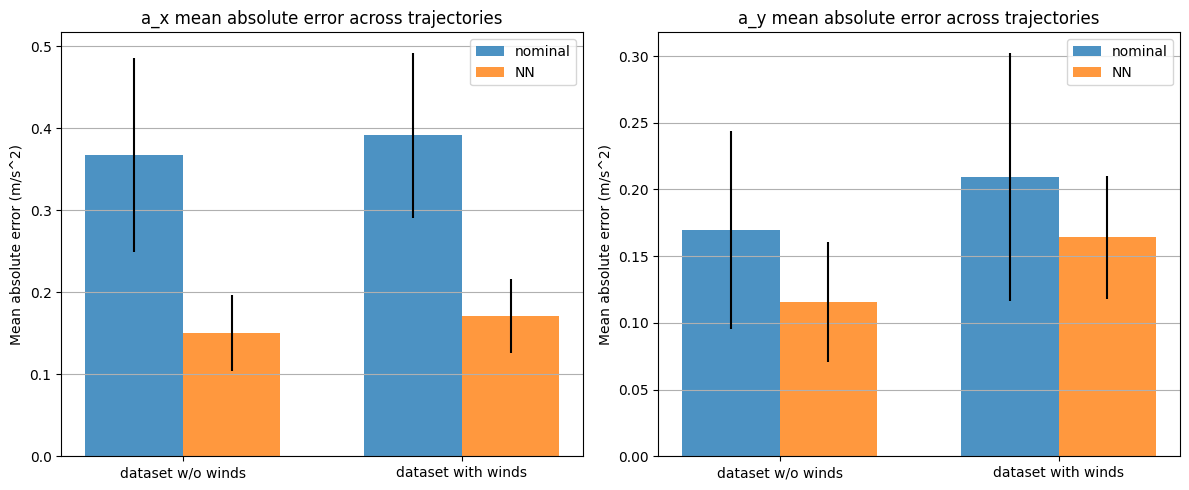

In [12]:
# compute mean absolute error per trajectory then average across trajectories for each dataset
datasets = {'dataset w/o winds': data_no_wind, 'dataset with winds': data_wind}
results = {}

for name, ds in datasets.items():
    ax_nom_means, ax_nn_means = [], []
    ay_nom_means, ay_nn_means = [], []
    for i in range(ds.num_trajectories):
        d = ds.trajectory_data[i]
        ax = np.array(d['ax'])
        ax_nom = np.array(d['ax_nominal'])
        ax_nn = np.array(d['ax_NN'])
        ay = np.array(d['ay'])
        ay_nom = np.array(d['ay_nominal'])
        ay_nn = np.array(d['ay_NN'])

        # mean abs error for this trajectory
        ax_nom_means.append(np.mean(np.abs(ax - ax_nom)))
        ax_nn_means.append(np.mean(np.abs(ax - ax_nn)))
        ay_nom_means.append(np.mean(np.abs(ay - ay_nom)))
        ay_nn_means.append(np.mean(np.abs(ay - ay_nn)))

    results[name] = {
        'ax_nom_mean_abs': float(np.mean(ax_nom_means)),
        'ax_nom_std': float(np.std(ax_nom_means)),
        'ax_nn_mean_abs': float(np.mean(ax_nn_means)),
        'ax_nn_std': float(np.std(ax_nn_means)),
        'ay_nom_mean_abs': float(np.mean(ay_nom_means)),
        'ay_nom_std': float(np.std(ay_nom_means)),
        'ay_nn_mean_abs': float(np.mean(ay_nn_means)),
        'ay_nn_std': float(np.std(ay_nn_means)),
        'num_profiles': ds.num_trajectories
    }

# optionally update the previously used summary variables
stats_no_wind = results['dataset w/o winds']
stats_wind = results['dataset with winds']

# print concise summary
for name, vals in results.items():
    print(f"{name}: N={vals['num_profiles']}")
    print(f"  ax: nominal mean abs={vals['ax_nom_mean_abs']:.4f} ± {vals['ax_nom_std']:.4f}, "
          f"NN mean abs={vals['ax_nn_mean_abs']:.4f} ± {vals['ax_nn_std']:.4f}")
    print(f"  ay: nominal mean abs={vals['ay_nom_mean_abs']:.4f} ± {vals['ay_nom_std']:.4f}, "
          f"NN mean abs={vals['ay_nn_mean_abs']:.4f} ± {vals['ay_nn_std']:.4f}")
    print()

# bar plot comparison (ax and ay)
labels = list(results.keys())
ax_nom_vals = [results[k]['ax_nom_mean_abs'] for k in labels]
ax_nn_vals  = [results[k]['ax_nn_mean_abs']  for k in labels]
ay_nom_vals = [results[k]['ay_nom_mean_abs'] for k in labels]
ay_nn_vals  = [results[k]['ay_nn_mean_abs']  for k in labels]

ax_nom_err = [results[k]['ax_nom_std'] for k in labels]
ax_nn_err  = [results[k]['ax_nn_std']  for k in labels]
ay_nom_err = [results[k]['ay_nom_std'] for k in labels]
ay_nn_err  = [results[k]['ay_nn_std']  for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(x - width/2, ax_nom_vals, width, yerr=ax_nom_err, label='nominal', alpha=0.8)
axes[0].bar(x + width/2, ax_nn_vals,  width, yerr=ax_nn_err,  label='NN',      alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel('Mean absolute error (m/s^2)')
axes[0].set_title('a_x mean absolute error across trajectories')
axes[0].legend()
axes[0].grid(True, axis='y')

axes[1].bar(x - width/2, ay_nom_vals, width, yerr=ay_nom_err, label='nominal', alpha=0.8)
axes[1].bar(x + width/2, ay_nn_vals,  width, yerr=ay_nn_err,  label='NN',      alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel('Mean absolute error (m/s^2)')
axes[1].set_title('a_y mean absolute error across trajectories')
axes[1].legend()
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()


In [8]:
## Code for Rolling out the trajectory using the nominal model and the NN model
# slider to browse trajectories and update the a_x / a_y plots
idx =0
traj_slider = ipywidgets.IntSlider(
    value=idx,
    min=0,
    max=data_no_wind.num_trajectories - 1,
    step=1,
    description='Trajectory Index:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

def _update_plots(change):
    i = change['new'] if isinstance(change, dict) else change
    with out:
        out.clear_output(wait=True)
        fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        axes[0].plot(data_no_wind.trajectory_data[i]['px'], label='px measured')
        axes[0].plot(data_no_wind.trajectory_data[i]['px_rollout_nominal'], label='px nominal')
        axes[0].plot(data_no_wind.trajectory_data[i]['px_rollout_NN'], label='px NN zero wind')
        axes[0].set_ylabel('p_x (m)')
        axes[0].set_title(f'Trajectory {i} - p_x')
        axes[0].legend()

        axes[1].plot(data_no_wind.trajectory_data[i]['py'], label='py measured')
        axes[1].plot(data_no_wind.trajectory_data[i]['py_rollout_nominal'], label='py nominal')
        axes[1].plot(data_no_wind.trajectory_data[i]['py_rollout_NN'], label='py NN zero wind')
        axes[1].set_ylabel('p_y (m)')
        axes[1].set_xlabel('Time Step')
        axes[1].set_title(f'Trajectory {i} - p_y')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

# hook up observer and display
traj_slider.observe(_update_plots, names='value')
display(traj_slider, out)

# draw initial plot
_update_plots({'new': traj_slider.value})

IntSlider(value=0, continuous_update=False, description='Trajectory Index:', max=37)

Output()

In [9]:
## Code for Rolling out the trajectory using the nominal model and the NN model
# slider to browse trajectories and update the a_x / a_y plots
idx =0
traj_slider = ipywidgets.IntSlider(
    value=idx,
    min=0,
    max=data_no_wind.num_trajectories - 1,
    step=1,
    description='Trajectory Index:',
    continuous_update=False,
    readout=True,
    readout_format='d'
)

def _update_plots(change):
    i = change['new'] if isinstance(change, dict) else change
    with out:
        out.clear_output(wait=True)
        fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        axes[0].plot(data_no_wind.trajectory_data[i]['vx'], label='vx measured')
        axes[0].plot(data_no_wind.trajectory_data[i]['vx_rollout_nominal'], label='vx nominal')
        axes[0].plot(data_no_wind.trajectory_data[i]['vx_rollout_NN'], label='vx NN zero wind')
        axes[0].set_ylabel('v_x (m/s)')
        axes[0].set_title(f'Trajectory {i} - v_x')
        axes[0].legend()

        axes[1].plot(data_no_wind.trajectory_data[i]['vy'], label='vy measured')
        axes[1].plot(data_no_wind.trajectory_data[i]['vy_rollout_nominal'], label='vy nominal')
        axes[1].plot(data_no_wind.trajectory_data[i]['vy_rollout_NN'], label='vy NN zero wind')
        axes[1].set_ylabel('v_y (m/s)')
        axes[1].set_xlabel('Time Step')
        axes[1].set_title(f'Trajectory {i} - v_y')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

# hook up observer and display
traj_slider.observe(_update_plots, names='value')
display(traj_slider, out)

# draw initial plot
_update_plots({'new': traj_slider.value})

IntSlider(value=0, continuous_update=False, description='Trajectory Index:', max=37)

Output()